# Clinical task generation

In [1]:
# General importations.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import string
from random import shuffle,seed,choices
from faker import Faker
from faker.providers.person.en import Provider
import networkx as nx
import itertools

from utils import Utils
from clinical_notes import TaskGenerator,DataSetGenerator

In [2]:
u = Utils()
dg = DataSetGenerator()

## Helper functions

In [3]:
def get_pns_ate(df, 
                verbose = True,
                return_value: str = "pns"):
    
    pns = u.get_pns_direct(df, 
                           y_do_x1 = "True (cause = True)", 
                           y_do_x0 = "True (cause = False)")
    ate = u.get_ate(df,
                    y_do_x1 = "True (cause = True)", 
                    y_do_x0 = "True (cause = False)")
    if verbose:
        print("PNS =", pns)
        print("ATE =", ate)
        
    if return_value == "pns":
        return pns
    elif return_value == "ate":
        return ate
    else:
        return pns,ate

## Error test (low complexity)

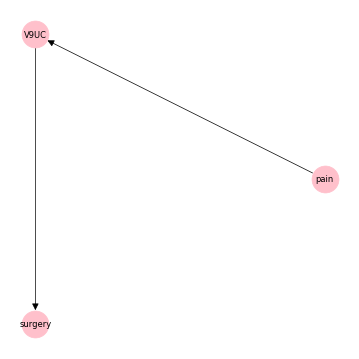


Context: Chronic disease 5POLPX sometimes requires surgical intervention, depending on genetics, patient history, vital signs, and lab results. The patient will experience significant pain (rated greater than or equal to 9/10) if they carry allele C3TG, a genetic marker for severe 5POLPX. If the patient self-reports significant pain or the patient has a family history of JMRF, then lab V9UC will be low (less than 3.43 mg/dL). If V9UC is low and the patient has previously received surgery for IQCV, then the surgeon will recommend surgery. Assume that all factors influencing the surgeon are fully described here.

Patient history: Now, we will review the history and physical notes for patient Yvonne Hopkins. History of Present Illness: Yvonne Hopkins is a 62-year-old female with 5POLPX who presented to the emergency department with acute onset pain that began 3 hours prior to arrival. Pain was rated 9/10. The patient reports the pain has been persistent since onset. The patient took aspi

In [4]:
size = [2,2]
tg = TaskGenerator(n_per_bcc = size, 
                   bcc_types = ["cycle"]*len(size))
context = tg.get_causal_context()
patient_history = tg.get_patient_history(n_extra_vars = 2)
print()
print("Context:", context)
print()
print("Patient history:", patient_history)
print()
print("- Global cause-effect pairs:", tg.get_global())
print("- Local cause-effect pairs:", tg.get_local())
print("- Compositions:", tg.get_compositions())

In [5]:
print()
print("- Factual queries:")
display(tg.get_factual_queries())


- Factual queries:


{'surgery': {'Prompt': 'Given these history and physical notes, will the surgeon recommend surgery? Begin your response with Yes or No and be as concise as possible.',
  'True endogenous': {'pain': 1, 'V9UC': 1, 'surgery': 0},
  'True exogenous': {'C3TG': 1, 'JMRF': 0, 'IQCV': 0},
  'True response': 0},
 'V9UC': {'Prompt': 'Given these history and physical notes, will lab V9UC be low? Begin your response with Yes or No and be as concise as possible.',
  'True endogenous': {'pain': 1, 'V9UC': 1, 'surgery': 0},
  'True exogenous': {'C3TG': 1, 'JMRF': 0, 'IQCV': 0},
  'True response': 1}}

In [6]:
cf_1, cf_0 = tg.get_counterfactual_queries()
print("- Counterfactual queries (cause = True):")
for key,val in cf_1.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

- Counterfactual queries (cause = True):

-----------------------

-- ('pain', 'surgery') --
Prompt: Now suppose that the patient will be in significant pain regardless of all other circumstances. With this new assumption, will the surgeon recommend surgery? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'pain': 1, 'V9UC': 1, 'surgery': 0}
True exogenous: {'C3TG': 1, 'JMRF': 0, 'IQCV': 0}
True response: 0

-----------------------

-- ('pain', 'V9UC') --
Prompt: Now suppose that the patient will be in significant pain regardless of all other circumstances. With this new assumption, will lab V9UC be low? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'pain': 1, 'V9UC': 1, 'surgery': 0}
True exogenous: {'C3TG': 1, 'JMRF': 0, 'IQCV': 0}
True response: 1

-----------------------

-- ('V9UC', 'surgery') --
Prompt: Now suppose that lab V9UC will be low regardless of all other circumstances. With this new assumption, wil

In [7]:
print("- Counterfactual queries (cause = False):")
for key,val in cf_0.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

- Counterfactual queries (cause = False):

-----------------------

-- ('pain', 'surgery') --
Prompt: Now suppose that the patient will not be in pain regardless of all other circumstances. With this new assumption, will the surgeon recommend surgery? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'pain': 0, 'V9UC': 0, 'surgery': 0}
True exogenous: {'C3TG': 1, 'JMRF': 0, 'IQCV': 0}
True response: 0

-----------------------

-- ('pain', 'V9UC') --
Prompt: Now suppose that the patient will not be in pain regardless of all other circumstances. With this new assumption, will lab V9UC be low? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'pain': 0, 'V9UC': 0, 'surgery': 0}
True exogenous: {'C3TG': 1, 'JMRF': 0, 'IQCV': 0}
True response: 0

-----------------------

-- ('V9UC', 'surgery') --
Prompt: Now suppose that lab V9UC will not be low regardless of all other circumstances. With this new assumption, will the surge

In [8]:
# Test observational data generation.
df_obs, df_noise = tg.sample_scm(n = 5,
                                 intervene_node = None,
                                 intervene_value = 0)
display(df_obs.head())
display(df_noise.head())

,pain,V9UC,surgery
0,1,1,0
1,1,1,1
2,0,1,1
3,0,0,0
4,0,0,0


,C3TG,JMRF,IQCV
0,1,0,0
1,1,1,1
2,0,1,1
3,0,0,1
4,0,0,1


In [9]:
# Test counterfactual data generation.
causes = set([x[0] for x in [tg.get_global()]+tg.get_local()])
intervene_value = 1
for cause in causes:
    print("\n-- {} = {} --".format(cause,intervene_value))
    df_obs, df_noise = tg.sample_scm(n = 5,
                                     intervene_node = cause,
                                     intervene_value = intervene_value)
    display(df_obs.head())
    display(df_noise.head())


-- pain = 1 --


,pain,V9UC,surgery
0,1,1,0
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1


,C3TG,JMRF,IQCV
0,1,0,0
1,1,1,1
2,0,1,1
3,0,0,1
4,0,0,1



-- V9UC = 1 --


,pain,V9UC,surgery
0,1,1,0
1,1,1,1
2,0,1,1
3,0,1,1
4,0,1,1


,C3TG,JMRF,IQCV
0,1,0,0
1,1,1,1
2,0,1,1
3,0,0,1
4,0,0,1


In [10]:
# Test counterfactual data generation.
causes = set([x[0] for x in [tg.get_global()]+tg.get_local()])
intervene_value = 0
for cause in causes:
    print("\n-- {} = {} --".format(cause,intervene_value))
    df_obs, df_noise = tg.sample_scm(n = 5,
                                     intervene_node = cause,
                                     intervene_value = intervene_value)
    display(df_obs.head())
    display(df_noise.head())


-- pain = 0 --


,pain,V9UC,surgery
0,0,0,0
1,0,1,1
2,0,1,1
3,0,0,0
4,0,0,0


,C3TG,JMRF,IQCV
0,1,0,0
1,1,1,1
2,0,1,1
3,0,0,1
4,0,0,1



-- V9UC = 0 --


,pain,V9UC,surgery
0,1,0,0
1,1,0,0
2,0,0,0
3,0,0,0
4,0,0,0


,C3TG,JMRF,IQCV
0,1,0,0
1,1,1,1
2,0,1,1
3,0,0,1
4,0,0,1


## Error test (moderate complexity)

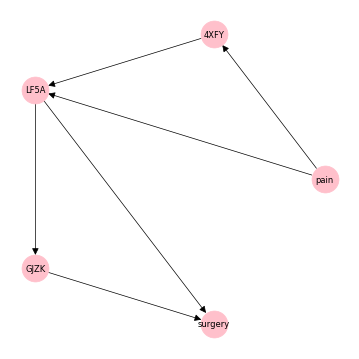


Context: Chronic disease HBO3ML sometimes requires surgical intervention, depending on genetics, patient history, vital signs, and lab results. The patient will experience significant pain (rated greater than or equal to 9/10) if they carry allele 4CTZ, a genetic marker for severe HBO3ML. If the patient self-reports significant pain or the patient has a family history of YDX8, then vital 4XFY will be low (less than 0.83 mg/dL). If the patient self-reports significant pain or 4XFY is low or the patient carries allele YVN9, then vital LF5A will be elevated (greater than 2.81 mg/dL). If LF5A is elevated or the patient carries allele JPF5, then lab GJZK will be elevated (greater than 2.39 mg/dL). If LF5A is elevated and GJZK is elevated and the patient has previously received surgery for LLF8, then the surgeon will recommend surgery. Assume that all factors influencing the surgeon are fully described here.

Patient history: Now, we will review the history and physical notes for patient Ro

In [11]:
size = [3,3]
tg = TaskGenerator(n_per_bcc = size, 
                   bcc_types = ["cycle"]*len(size))
context = tg.get_causal_context()
patient_history = tg.get_patient_history(n_extra_vars = 2)
print()
print("Context:", context)
print()
print("Patient history:", patient_history)
print()
print("- Global cause-effect pairs:", tg.get_global())
print("- Local cause-effect pairs:", tg.get_local())
print("- Compositions:", tg.get_compositions())

In [12]:
print()
print("- Factual queries:")
display(tg.get_factual_queries())


- Factual queries:


{'surgery': {'Prompt': 'Given these history and physical notes, will the surgeon recommend surgery? Begin your response with Yes or No and be as concise as possible.',
  'True endogenous': {'pain': 0,
   '4XFY': 0,
   'LF5A': 1,
   'GJZK': 1,
   'surgery': 1},
  'True exogenous': {'4CTZ': 0, 'YDX8': 0, 'YVN9': 1, 'JPF5': 0, 'LLF8': 1},
  'True response': 1},
 'LF5A': {'Prompt': 'Given these history and physical notes, will vital LF5A be elevated? Begin your response with Yes or No and be as concise as possible.',
  'True endogenous': {'pain': 0,
   '4XFY': 0,
   'LF5A': 1,
   'GJZK': 1,
   'surgery': 1},
  'True exogenous': {'4CTZ': 0, 'YDX8': 0, 'YVN9': 1, 'JPF5': 0, 'LLF8': 1},
  'True response': 1}}

In [13]:
cf_1, cf_0 = tg.get_counterfactual_queries()
print("- Counterfactual queries (cause = True):")
for key,val in cf_1.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

- Counterfactual queries (cause = True):

-----------------------

-- ('pain', 'surgery') --
Prompt: Now suppose that the patient will be in significant pain regardless of all other circumstances. With this new assumption, will the surgeon recommend surgery? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'pain': 1, '4XFY': 1, 'LF5A': 1, 'GJZK': 1, 'surgery': 1}
True exogenous: {'4CTZ': 0, 'YDX8': 0, 'YVN9': 1, 'JPF5': 0, 'LLF8': 1}
True response: 1

-----------------------

-- ('pain', 'LF5A') --
Prompt: Now suppose that the patient will be in significant pain regardless of all other circumstances. With this new assumption, will vital LF5A be elevated? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'pain': 1, '4XFY': 1, 'LF5A': 1, 'GJZK': 1, 'surgery': 1}
True exogenous: {'4CTZ': 0, 'YDX8': 0, 'YVN9': 1, 'JPF5': 0, 'LLF8': 1}
True response: 1

-----------------------

-- ('LF5A', 'surgery') --
Prompt: Now suppose

In [14]:
print("- Counterfactual queries (cause = False):")
for key,val in cf_0.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

- Counterfactual queries (cause = False):

-----------------------

-- ('pain', 'surgery') --
Prompt: Now suppose that the patient will not be in pain regardless of all other circumstances. With this new assumption, will the surgeon recommend surgery? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'pain': 0, '4XFY': 0, 'LF5A': 1, 'GJZK': 1, 'surgery': 1}
True exogenous: {'4CTZ': 0, 'YDX8': 0, 'YVN9': 1, 'JPF5': 0, 'LLF8': 1}
True response: 1

-----------------------

-- ('pain', 'LF5A') --
Prompt: Now suppose that the patient will not be in pain regardless of all other circumstances. With this new assumption, will vital LF5A be elevated? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'pain': 0, '4XFY': 0, 'LF5A': 1, 'GJZK': 1, 'surgery': 1}
True exogenous: {'4CTZ': 0, 'YDX8': 0, 'YVN9': 1, 'JPF5': 0, 'LLF8': 1}
True response: 1

-----------------------

-- ('LF5A', 'surgery') --
Prompt: Now suppose that vital LF5

In [15]:
# Test observational data generation.
df_obs, df_noise = tg.sample_scm(n = 5,
                                 intervene_node = None,
                                 intervene_value = 0)
display(df_obs.head())
display(df_noise.head())

,pain,4XFY,LF5A,GJZK,surgery
0,1,1,1,1,0
1,1,1,1,1,0
2,0,1,1,1,1
3,0,0,1,1,0
4,0,0,1,1,0


,4CTZ,YDX8,YVN9,JPF5,LLF8
0,1,0,0,1,0
1,1,1,1,0,0
2,0,1,1,0,1
3,0,0,1,1,0
4,0,0,1,1,0


In [16]:
# Test counterfactual data generation.
causes = set([x[0] for x in [tg.get_global()]+tg.get_local()])
intervene_value = 1
for cause in causes:
    print("\n-- {} = {} --".format(cause,intervene_value))
    df_obs, df_noise = tg.sample_scm(n = 5,
                                     intervene_node = cause,
                                     intervene_value = intervene_value)
    display(df_obs.head())
    display(df_noise.head())


-- pain = 1 --


,pain,4XFY,LF5A,GJZK,surgery
0,1,1,1,1,0
1,1,1,1,1,0
2,1,1,1,1,1
3,1,1,1,1,0
4,1,1,1,1,0


,4CTZ,YDX8,YVN9,JPF5,LLF8
0,1,0,0,1,0
1,1,1,1,0,0
2,0,1,1,0,1
3,0,0,1,1,0
4,0,0,1,1,0



-- LF5A = 1 --


,pain,4XFY,LF5A,GJZK,surgery
0,1,1,1,1,0
1,1,1,1,1,0
2,0,1,1,1,1
3,0,0,1,1,0
4,0,0,1,1,0


,4CTZ,YDX8,YVN9,JPF5,LLF8
0,1,0,0,1,0
1,1,1,1,0,0
2,0,1,1,0,1
3,0,0,1,1,0
4,0,0,1,1,0


In [17]:
# Test counterfactual data generation.
causes = set([x[0] for x in [tg.get_global()]+tg.get_local()])
intervene_value = 0
for cause in causes:
    print("\n-- {} = {} --".format(cause,intervene_value))
    df_obs, df_noise = tg.sample_scm(n = 5,
                                     intervene_node = cause,
                                     intervene_value = intervene_value)
    display(df_obs.head())
    display(df_noise.head())


-- pain = 0 --


,pain,4XFY,LF5A,GJZK,surgery
0,0,0,0,1,0
1,0,1,1,1,0
2,0,1,1,1,1
3,0,0,1,1,0
4,0,0,1,1,0


,4CTZ,YDX8,YVN9,JPF5,LLF8
0,1,0,0,1,0
1,1,1,1,0,0
2,0,1,1,0,1
3,0,0,1,1,0
4,0,0,1,1,0



-- LF5A = 0 --


,pain,4XFY,LF5A,GJZK,surgery
0,1,1,0,1,0
1,1,1,0,0,0
2,0,1,0,0,0
3,0,0,0,1,0
4,0,0,0,1,0


,4CTZ,YDX8,YVN9,JPF5,LLF8
0,1,0,0,1,0
1,1,1,1,0,0
2,0,1,1,0,1
3,0,0,1,1,0
4,0,0,1,1,0


In [18]:
glo = [tg.get_global()]
loc = tg.get_local()
comp = tg.get_compositions()

print(glo)
print(loc)
print(comp)

[('pain', 'surgery')]
[('pain', 'LF5A'), ('LF5A', 'surgery')]
[[('pain', 'LF5A'), ('LF5A', 'surgery')]]


In [19]:
# Get PNS and compare to ATE.
results_dict = dict()
for n in [5,10,50,100,500,1000,5000]:
    pair_dict = dict()
    for pair in glo+loc:
        df_cf, df_noise = tg.sample_scm(n = n,
                                        intervene_node = pair[0],
                                        intervene_value = 1)
        df_cf.rename(columns={pair[1]: 'True (cause = True)'}, inplace = True)
        df_cf_0, df_noise = tg.sample_scm(n = n,
                                          intervene_node = pair[0],
                                          intervene_value = 0)
        df_cf["True (cause = False)"] = df_cf_0[pair[1]]
        display(df_cf.head(5))
        print("\n-- {} | n = {} --".format(pair,n))
        pns = get_pns_ate(df_cf)
        pair_dict[pair] = pns
    results_dict[n] = pair_dict

,pain,4XFY,LF5A,GJZK,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,0
2,1,1,1,1,1,1
3,1,1,1,1,0,0
4,1,1,1,1,0,0



-- ('pain', 'surgery') | n = 5 --
PNS = 0.0
ATE = 0.0


,pain,4XFY,True (cause = True),GJZK,surgery,True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,1
2,1,1,1,1,1,1
3,1,1,1,1,0,1
4,1,1,1,1,0,1



-- ('pain', 'LF5A') | n = 5 --
PNS = 0.2
ATE = 0.19999999999999996


,pain,4XFY,LF5A,GJZK,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,0
2,0,1,1,1,1,0
3,0,0,1,1,0,0
4,0,0,1,1,0,0



-- ('LF5A', 'surgery') | n = 5 --
PNS = 0.2
ATE = 0.2


,pain,4XFY,LF5A,GJZK,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,0
2,1,1,1,1,1,1
3,1,1,1,1,1,1
4,1,1,1,1,1,1



-- ('pain', 'surgery') | n = 10 --
PNS = 0.0
ATE = 0.0


,pain,4XFY,True (cause = True),GJZK,surgery,True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,1
2,1,1,1,1,1,1
3,1,1,1,1,1,1
4,1,1,1,1,1,1



-- ('pain', 'LF5A') | n = 10 --
PNS = 0.1
ATE = 0.09999999999999998


,pain,4XFY,LF5A,GJZK,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,0
2,0,1,1,1,1,0
3,0,1,1,1,1,0
4,0,1,1,1,1,0



-- ('LF5A', 'surgery') | n = 10 --
PNS = 0.6
ATE = 0.6


,pain,4XFY,LF5A,GJZK,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,1,1
2,1,1,1,1,0,0
3,1,1,1,1,0,0
4,1,1,1,1,1,1



-- ('pain', 'surgery') | n = 50 --
PNS = 0.06
ATE = 0.06


,pain,4XFY,True (cause = True),GJZK,surgery,True (cause = False)
0,1,1,1,1,0,1
1,1,1,1,1,1,1
2,1,1,1,1,0,1
3,1,1,1,1,0,1
4,1,1,1,1,1,1



-- ('pain', 'LF5A') | n = 50 --
PNS = 0.18
ATE = 0.18000000000000005


,pain,4XFY,LF5A,GJZK,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,1,0
2,0,1,1,1,0,0
3,0,1,1,1,0,0
4,0,0,1,1,1,0



-- ('LF5A', 'surgery') | n = 50 --
PNS = 0.52
ATE = 0.52


,pain,4XFY,LF5A,GJZK,True (cause = True),True (cause = False)
0,1,1,1,1,1,1
1,1,1,1,1,0,0
2,1,1,1,1,1,1
3,1,1,1,1,0,0
4,1,1,1,1,1,1



-- ('pain', 'surgery') | n = 100 --
PNS = 0.13
ATE = 0.13


,pain,4XFY,True (cause = True),GJZK,surgery,True (cause = False)
0,1,1,1,1,1,1
1,1,1,1,1,0,1
2,1,1,1,1,1,1
3,1,1,1,1,0,1
4,1,1,1,1,1,1



-- ('pain', 'LF5A') | n = 100 --
PNS = 0.26
ATE = 0.26


,pain,4XFY,LF5A,GJZK,True (cause = True),True (cause = False)
0,1,1,1,1,1,0
1,1,1,1,1,0,0
2,0,1,1,1,1,0
3,0,1,1,1,0,0
4,0,1,1,1,1,0



-- ('LF5A', 'surgery') | n = 100 --
PNS = 0.51
ATE = 0.51


,pain,4XFY,LF5A,GJZK,True (cause = True),True (cause = False)
0,1,1,1,1,1,0
1,1,1,1,1,0,0
2,1,1,1,1,1,1
3,1,1,1,1,0,0
4,1,1,1,1,1,1



-- ('pain', 'surgery') | n = 500 --
PNS = 0.138
ATE = 0.138


,pain,4XFY,True (cause = True),GJZK,surgery,True (cause = False)
0,1,1,1,1,1,0
1,1,1,1,1,0,0
2,1,1,1,1,1,1
3,1,1,1,1,0,0
4,1,1,1,1,1,1



-- ('pain', 'LF5A') | n = 500 --
PNS = 0.25
ATE = 0.25


,pain,4XFY,LF5A,GJZK,True (cause = True),True (cause = False)
0,1,1,1,1,1,0
1,1,1,1,1,0,0
2,0,1,1,1,1,0
3,0,0,1,1,0,0
4,0,1,1,1,1,0



-- ('LF5A', 'surgery') | n = 500 --
PNS = 0.512
ATE = 0.512


,pain,4XFY,LF5A,GJZK,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,1,0
2,1,1,1,1,0,0
3,1,1,1,1,1,0
4,1,1,1,1,0,0



-- ('pain', 'surgery') | n = 1000 --
PNS = 0.12
ATE = 0.12


,pain,4XFY,True (cause = True),GJZK,surgery,True (cause = False)
0,1,1,1,1,0,1
1,1,1,1,1,1,0
2,1,1,1,1,0,1
3,1,1,1,1,1,0
4,1,1,1,1,0,1



-- ('pain', 'LF5A') | n = 1000 --
PNS = 0.251
ATE = 0.251


,pain,4XFY,LF5A,GJZK,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,1,0
2,0,0,1,1,0,0
3,0,0,1,1,1,0
4,0,1,1,1,0,0



-- ('LF5A', 'surgery') | n = 1000 --
PNS = 0.492
ATE = 0.492


,pain,4XFY,LF5A,GJZK,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,0
2,1,1,1,1,1,0
3,1,1,1,1,0,0
4,1,1,1,1,0,0



-- ('pain', 'surgery') | n = 5000 --
PNS = 0.123
ATE = 0.123


,pain,4XFY,True (cause = True),GJZK,surgery,True (cause = False)
0,1,1,1,1,0,1
1,1,1,1,1,0,1
2,1,1,1,1,1,0
3,1,1,1,1,0,1
4,1,1,1,1,0,1



-- ('pain', 'LF5A') | n = 5000 --
PNS = 0.2456
ATE = 0.24560000000000004


,pain,4XFY,LF5A,GJZK,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,0
2,0,0,1,1,1,0
3,0,1,1,1,0,0
4,0,1,1,1,0,0



-- ('LF5A', 'surgery') | n = 5000 --
PNS = 0.4914
ATE = 0.4914


In [20]:
for n,res in results_dict.items():
    print("\n-- n = {} --".format(n))
    comp_pns = 1
    for pair,pns in res.items():
        if pair == glo[0]:
            global_pns = pns
        else:
            comp_pns *= pns
    print("Global PNS  =", global_pns)
    print("Composition =", comp_pns)


-- n = 5 --
Global PNS  = 0.0
Composition = 0.04000000000000001

-- n = 10 --
Global PNS  = 0.0
Composition = 0.06

-- n = 50 --
Global PNS  = 0.06
Composition = 0.0936

-- n = 100 --
Global PNS  = 0.13
Composition = 0.1326

-- n = 500 --
Global PNS  = 0.138
Composition = 0.128

-- n = 1000 --
Global PNS  = 0.12
Composition = 0.123492

-- n = 5000 --
Global PNS  = 0.123
Composition = 0.12068784


In [21]:
results_dict

{5: {('pain', 'surgery'): 0.0,
  ('pain', 'LF5A'): 0.2,
  ('LF5A', 'surgery'): 0.2},
 10: {('pain', 'surgery'): 0.0,
  ('pain', 'LF5A'): 0.1,
  ('LF5A', 'surgery'): 0.6},
 50: {('pain', 'surgery'): 0.06,
  ('pain', 'LF5A'): 0.18,
  ('LF5A', 'surgery'): 0.52},
 100: {('pain', 'surgery'): 0.13,
  ('pain', 'LF5A'): 0.26,
  ('LF5A', 'surgery'): 0.51},
 500: {('pain', 'surgery'): 0.138,
  ('pain', 'LF5A'): 0.25,
  ('LF5A', 'surgery'): 0.512},
 1000: {('pain', 'surgery'): 0.12,
  ('pain', 'LF5A'): 0.251,
  ('LF5A', 'surgery'): 0.492},
 5000: {('pain', 'surgery'): 0.123,
  ('pain', 'LF5A'): 0.2456,
  ('LF5A', 'surgery'): 0.4914}}

## Generate dataset

In [109]:
# x levels of graphical complexity (captured by BCC size).
# y tasks per graphical complexity level.
# z samples per task.
# = x*y*z subtasks.
graph_sizes = [[2,2],[2,2,2],[3,3],[3,3,3]]
n_tasks_per_size = 5
n_samples_per_task = 1000

df = dg.get_dataset(graph_sizes = graph_sizes,
                    n_tasks_per_size = n_tasks_per_size,
                    n_samples_per_task = n_samples_per_task)

display(df)

,Task ID,Context ID,Sample ID,Nodes per BCC,Causal context,DAG adjacency matrix,DAG nodes,CCT adjacency matrix,CCT nodes,Global quantity,Local quantities,Compositions,Patient history,Factual queries,Counterfactual queries (cause = True),Counterfactual queries (cause = False)
0,0.0.2,0,0,2,Chronic disease HONJ0U sometimes requires surg...,"[[0, 1, 0], [0, 0, 1], [0, 0, 0]]","[pain, HWKA, surgery]","[[0.0, 1.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, ...","[pain, HWKA, surgery]","(pain, surgery)","[(pain, HWKA), (HWKA, surgery)]","[[(pain, HWKA), (HWKA, surgery)]]","Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
1,0.1.2,0,1,2,Chronic disease HONJ0U sometimes requires surg...,"[[0, 1, 0], [0, 0, 1], [0, 0, 0]]","[pain, HWKA, surgery]","[[0.0, 1.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, ...","[pain, HWKA, surgery]","(pain, surgery)","[(pain, HWKA), (HWKA, surgery)]","[[(pain, HWKA), (HWKA, surgery)]]","Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
2,0.2.2,0,2,2,Chronic disease HONJ0U sometimes requires surg...,"[[0, 1, 0], [0, 0, 1], [0, 0, 0]]","[pain, HWKA, surgery]","[[0.0, 1.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, ...","[pain, HWKA, surgery]","(pain, surgery)","[(pain, HWKA), (HWKA, surgery)]","[[(pain, HWKA), (HWKA, surgery)]]","Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
3,0.3.2,0,3,2,Chronic disease HONJ0U sometimes requires surg...,"[[0, 1, 0], [0, 0, 1], [0, 0, 0]]","[pain, HWKA, surgery]","[[0.0, 1.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, ...","[pain, HWKA, surgery]","(pain, surgery)","[(pain, HWKA), (HWKA, surgery)]","[[(pain, HWKA), (HWKA, surgery)]]","Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
4,0.4.2,0,4,2,Chronic disease HONJ0U sometimes requires surg...,"[[0, 1, 0], [0, 0, 1], [0, 0, 0]]","[pain, HWKA, surgery]","[[0.0, 1.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, ...","[pain, HWKA, surgery]","(pain, surgery)","[(pain, HWKA), (HWKA, surgery)]","[[(pain, HWKA), (HWKA, surgery)]]","Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19.995.3,19,995,3,Chronic disease H6SR5J sometimes requires surg...,"[[0, 1, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0],...","[pain, XCWK, PO29, IY2X, KHSR, HMWX, surgery]","[[0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [...","[pain, PO29, KHSR, surgery]","(pain, surgery)","[(pain, PO29), (pain, KHSR), (PO29, KHSR), (PO...","[[(pain, PO29), (PO29, KHSR), (KHSR, surgery)]...","Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
19996,19.996.3,19,996,3,Chronic disease H6SR5J sometimes requires surg...,"[[0, 1, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0],...","[pain, XCWK, PO29, IY2X, KHSR, HMWX, surgery]","[[0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [...","[pain, PO29, KHSR, surgery]","(pain, surgery)","[(pain, PO29), (pain, KHSR), (PO29, KHSR), (PO...","[[(pain, PO29), (PO29, KHSR), (KHSR, surgery)]...","Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
19997,19.997.3,19,

In [110]:
# Process prompts.
df_factual, df_cf = dg.process_prompts(df)
display(df_factual)
display(df_cf)

,Context ID,Nodes per BCC,Task ID,Effect,Prompt,True
0,0,2,0.0.2,surgery,Chronic disease HONJ0U sometimes requires surg...,1
1,0,2,0.0.2,HWKA,Chronic disease HONJ0U sometimes requires surg...,1
2,0,2,0.1.2,surgery,Chronic disease HONJ0U sometimes requires surg...,1
3,0,2,0.1.2,HWKA,Chronic disease HONJ0U sometimes requires surg...,1
4,0,2,0.2.2,surgery,Chronic disease HONJ0U sometimes requires surg...,1
...,...,...,...,...,...,...
49995,19,3,19.998.3,PO29,Chronic disease H6SR5J sometimes requires surg...,1
49996,19,3,19.998.3,KHSR,Chronic disease H6SR5J sometimes requires surg...,1
49997,19,3,19.999.3,surgery,Chronic disease H6SR5J sometimes requires surg...,0
49998,19,3,19.999.3,PO29,Chronic disease H6SR5J sometimes requires surg...,1


,Context ID,Nodes per BCC,Task ID,Cause-effect pair,Cause,Effect,Prompt (cause = True),True (cause = True),Prompt (cause = False),True (cause = False)
0,0,2,0.0.2,"(pain, surgery)",pain,surgery,Chronic disease HONJ0U sometimes requires surg...,1,Chronic disease HONJ0U sometimes requires surg...,0
1,0,2,0.0.2,"(pain, HWKA)",pain,HWKA,Chronic disease HONJ0U sometimes requires surg...,1,Chronic disease HONJ0U sometimes requires surg...,0
2,0,2,0.0.2,"(HWKA, surgery)",HWKA,surgery,Chronic disease HONJ0U sometimes requires surg...,1,Chronic disease HONJ0U sometimes requires surg...,0
3,0,2,0.1.2,"(pain, surgery)",pain,surgery,Chronic disease HONJ0U sometimes requires surg...,1,Chronic disease HONJ0U sometimes requires surg...,1
4,0,2,0.1.2,"(pain, HWKA)",pain,HWKA,Chronic disease HONJ0U sometimes requires surg...,1,Chronic disease HONJ0U sometimes requires surg...,1
...,...,...,...,...,...,...,...,...,...,...
89995,19,3,19.999.3,"(pain, PO29)",pain,PO29,Chronic disease H6SR5J sometimes requires surg...,1,Chronic disease H6SR5J sometimes requires surg...,1
89996,19,3,19.999.3,"(pain, KHSR)",pain,KHSR,Chronic disease H6SR5J sometimes requires surg...,1,Chronic disease H6SR5J sometimes requires surg...,1
89997,19,3,19.999.3,"(PO29, KHSR)",PO29,KHSR,Chronic disease H6SR5J sometimes requires surg...,1,Chronic disease H6SR5J sometimes requires surg...,1
89998,19,3,19.999.3,"(PO29, surgery)",PO29,surgery,Chronic disease H6SR5J sometimes requires surg...,0,Chronic disease H6SR5J sometimes requires surg...,0


In [112]:
df_cf_0 = df_cf[df_cf["Context ID"] == 0]
df_cf_0

,Context ID,Nodes per BCC,Task ID,Cause-effect pair,Cause,Effect,Prompt (cause = True),True (cause = True),Prompt (cause = False),True (cause = False)
0,0,2,0.0.2,"(pain, surgery)",pain,surgery,Chronic disease HONJ0U sometimes requires surg...,1,Chronic disease HONJ0U sometimes requires surg...,0
1,0,2,0.0.2,"(pain, HWKA)",pain,HWKA,Chronic disease HONJ0U sometimes requires surg...,1,Chronic disease HONJ0U sometimes requires surg...,0
2,0,2,0.0.2,"(HWKA, surgery)",HWKA,surgery,Chronic disease HONJ0U sometimes requires surg...,1,Chronic disease HONJ0U sometimes requires surg...,0
3,0,2,0.1.2,"(pain, surgery)",pain,surgery,Chronic disease HONJ0U sometimes requires surg...,1,Chronic disease HONJ0U sometimes requires surg...,1
4,0,2,0.1.2,"(pain, HWKA)",pain,HWKA,Chronic disease HONJ0U sometimes requires surg...,1,Chronic disease HONJ0U sometimes requires surg...,1
...,...,...,...,...,...,...,...,...,...,...
2995,0,2,0.998.2,"(pain, HWKA)",pain,HWKA,Chronic disease HONJ0U sometimes requires surg...,1,Chronic disease HONJ0U sometimes requires surg...,0
2996,0,2,0.998.2,"(HWKA, surgery)",HWKA,surgery,Chronic disease HONJ0U sometimes requires surg...,1,Chronic disease HONJ0U sometimes requires surg...,0
2997,0,2,0.999.2,"(pain, surgery)",pain,surgery,Chronic disease HONJ0U sometimes requires surg...,0,Chronic disease HONJ0U sometimes requires surg...,0
2998,0,2,0.999.2,"(pain, HWKA)",pain,HWKA,Chronic disease HONJ0U sometimes requires surg...,1,Chronic disease HONJ0U sometimes requires surg...,0


In [113]:
df_cf_0["Prompt (cause = True)"][1]

'Chronic disease HONJ0U sometimes requires surgical intervention, depending on genetics, patient history, vital signs, and lab results. The patient will experience significant pain (rated greater than or equal to 8/10) if they carry allele YEJZ, a genetic marker for severe HONJ0U. If the patient self-reports significant pain or the patient has a family history of SCE1, then vital HWKA will be low (less than 3.17 mg/dL). If HWKA is low and the patient has a family history of Y4XW, then the surgeon will recommend surgery. Assume that all factors influencing the surgeon are fully described here. Now, we will review the history and physical notes for patient Samantha Williams. History of Present Illness: Samantha Williams is a 55-year-old female with HONJ0U who presented to the emergency department with acute onset pain that began 5 hours prior to arrival. Pain was rated 8/10. The patient reports the pain has been persistent since onset. The patient took aspirin (500 mg) at home with minim

In [114]:
df_cf_0["Prompt (cause = False)"][1]

'Chronic disease HONJ0U sometimes requires surgical intervention, depending on genetics, patient history, vital signs, and lab results. The patient will experience significant pain (rated greater than or equal to 8/10) if they carry allele YEJZ, a genetic marker for severe HONJ0U. If the patient self-reports significant pain or the patient has a family history of SCE1, then vital HWKA will be low (less than 3.17 mg/dL). If HWKA is low and the patient has a family history of Y4XW, then the surgeon will recommend surgery. Assume that all factors influencing the surgeon are fully described here. Now, we will review the history and physical notes for patient Samantha Williams. History of Present Illness: Samantha Williams is a 55-year-old female with HONJ0U who presented to the emergency department with acute onset pain that began 5 hours prior to arrival. Pain was rated 8/10. The patient reports the pain has been persistent since onset. The patient took aspirin (500 mg) at home with minim

In [116]:
context_dict = dict()
for context_id in df_cf["Context ID"].unique():
    df_context = df_cf[df_cf["Context ID"] == context_id]
    pair_dict = dict()
    for pair in df_context["Cause-effect pair"].unique():
        print(pair)
        pair_dict[pair] = get_pns_ate(df_context[df_context["Cause-effect pair"] == pair], 
                                      verbose = True,
                                      return_value = "pns")
    context_dict[context_id] = pair_dict

('pain', 'surgery')
PNS = 0.259
ATE = 0.259
('pain', 'HWKA')
PNS = 0.507
ATE = 0.507
('HWKA', 'surgery')
PNS = 0.506
ATE = 0.506
('pain', 'surgery')
PNS = 0.26
ATE = 0.26
('pain', 'AY2J')
PNS = 0.512
ATE = 0.512
('AY2J', 'surgery')
PNS = 0.502
ATE = 0.502
('pain', 'surgery')
PNS = 0.224
ATE = 0.22399999999999998
('pain', 'G0XL')
PNS = 0.487
ATE = 0.487
('G0XL', 'surgery')
PNS = 0.475
ATE = 0.475
('pain', 'surgery')
PNS = 0.242
ATE = 0.242
('pain', 'SE9Y')
PNS = 0.47
ATE = 0.47
('SE9Y', 'surgery')
PNS = 0.516
ATE = 0.516
('pain', 'surgery')
PNS = 0.269
ATE = 0.269
('pain', '8WGX')
PNS = 0.526
ATE = 0.526
('8WGX', 'surgery')
PNS = 0.509
ATE = 0.509
('pain', 'surgery')
PNS = 0.143
ATE = 0.14300000000000002
('pain', 'SWHN')
PNS = 0.494
ATE = 0.494
('pain', 'A5VO')
PNS = 0.255
ATE = 0.255
('SWHN', 'A5VO')
PNS = 0.505
ATE = 0.505
('SWHN', 'surgery')
PNS = 0.266
ATE = 0.266
('A5VO', 'surgery')
PNS = 0.522
ATE = 0.522
('pain', 'surgery')
PNS = 0.127
ATE = 0.127
('pain', 'ETZZ')
PNS = 0.502
ATE

In [117]:
context_dict

{0: {('pain', 'surgery'): 0.259,
  ('pain', 'HWKA'): 0.507,
  ('HWKA', 'surgery'): 0.506},
 1: {('pain', 'surgery'): 0.26,
  ('pain', 'AY2J'): 0.512,
  ('AY2J', 'surgery'): 0.502},
 2: {('pain', 'surgery'): 0.224,
  ('pain', 'G0XL'): 0.487,
  ('G0XL', 'surgery'): 0.475},
 3: {('pain', 'surgery'): 0.242,
  ('pain', 'SE9Y'): 0.47,
  ('SE9Y', 'surgery'): 0.516},
 4: {('pain', 'surgery'): 0.269,
  ('pain', '8WGX'): 0.526,
  ('8WGX', 'surgery'): 0.509},
 5: {('pain', 'surgery'): 0.143,
  ('pain', 'SWHN'): 0.494,
  ('pain', 'A5VO'): 0.255,
  ('SWHN', 'A5VO'): 0.505,
  ('SWHN', 'surgery'): 0.266,
  ('A5VO', 'surgery'): 0.522},
 6: {('pain', 'surgery'): 0.127,
  ('pain', 'ETZZ'): 0.502,
  ('pain', 'MCH9'): 0.239,
  ('ETZZ', 'MCH9'): 0.499,
  ('ETZZ', 'surgery'): 0.252,
  ('MCH9', 'surgery'): 0.509},
 7: {('pain', 'surgery'): 0.136,
  ('pain', '2ZRE'): 0.487,
  ('pain', 'GGZL'): 0.254,
  ('2ZRE', 'GGZL'): 0.527,
  ('2ZRE', 'surgery'): 0.285,
  ('GGZL', 'surgery'): 0.522},
 8: {('pain', 'surgery

In [128]:
for context_id in df["Context ID"].unique():
    df_context = df[df["Context ID"] == context_id]
    compositions = df_context["Compositions"].value_counts().index.item()
    res = context_dict.get(context_id)
    print("\n-- context {} --".format(context_id))
    print(res)
    print("\nGlobal =", res.get(('pain', 'surgery')))
    for comp in compositions:
        pns = 1
        for pair in comp:
            pns *= res.get(pair)
        print(comp, "=", pns)
    print("\n-----------------------------------")


-- context 0 --
{('pain', 'surgery'): 0.259, ('pain', 'HWKA'): 0.507, ('HWKA', 'surgery'): 0.506}

Global = 0.259
[('pain', 'HWKA'), ('HWKA', 'surgery')] = 0.256542

-----------------------------------

-- context 1 --
{('pain', 'surgery'): 0.26, ('pain', 'AY2J'): 0.512, ('AY2J', 'surgery'): 0.502}

Global = 0.26
[('pain', 'AY2J'), ('AY2J', 'surgery')] = 0.25702400000000003

-----------------------------------

-- context 2 --
{('pain', 'surgery'): 0.224, ('pain', 'G0XL'): 0.487, ('G0XL', 'surgery'): 0.475}

Global = 0.224
[('pain', 'G0XL'), ('G0XL', 'surgery')] = 0.23132499999999998

-----------------------------------

-- context 3 --
{('pain', 'surgery'): 0.242, ('pain', 'SE9Y'): 0.47, ('SE9Y', 'surgery'): 0.516}

Global = 0.242
[('pain', 'SE9Y'), ('SE9Y', 'surgery')] = 0.24251999999999999

-----------------------------------

-- context 4 --
{('pain', 'surgery'): 0.269, ('pain', '8WGX'): 0.526, ('8WGX', 'surgery'): 0.509}

Global = 0.269
[('pain', '8WGX'), ('8WGX', 'surgery')] = 0

## End of document